# Adversarial-Vulnerability

Understanding vulnerability of video classification model towards adversarial attacks.
Code by:

    Krishna Srikar Durbha - EE18BTECH11014
    Varun Shankar Moparthi - EE18BTECH11030

## Imports

### Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import imageio
import cv2
import scipy
import os
import random
from sklearn.metrics import accuracy_score

# Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, LSTM, GRU, Dropout, Reshape, Conv1D, MaxPooling1D, MaxPooling2D, Concatenate

# Installing tqdm
!pip3 install tqdm
from tqdm import tqdm

# Installing Cleverhans
!pip3 install cleverhans
import cleverhans

# Import attacks
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

### Connecting to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Video-Classification

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Video-Classification


### Importing Dataset

In [ ]:
# Path for Videos and Features
Videos_Path = "Datasets/Videos"
Features_Path = "Datasets/Features"

# Interested no.of classes
N = 30

# Test Image
Test_Image = np.repeat(np.expand_dims(cv2.resize(pimg.imread("Datasets/Image.jpg"), (128,128)), axis=0), 20, axis=0)

# Classes
Classes = os.listdir(Features_Path)
Classes.sort()
Classes = Classes[:N]
Classes2Index = dict(zip(Classes, np.arange(len(Classes))))
Index2Classes = dict(zip(np.arange(len(Classes)), Classes))

## Constructing Classification Model

Constructing a complete end-to-end classification model using InceptionNetV3 and Classification RNN Network.

Feature Extraction Model and CLassifier

In [ ]:
# Feature Extraction Model
FeatureExtractor = tf.keras.models.load_model("Models/Feature-Extraction_Model.h5")

# Classifier
Classifier = tf.keras.models.load_model("Models/Video-Classification_Model.h5")

# Input Preprocessing Function
Preprocess_Input = tf.keras.applications.inception_v3.preprocess_input

Constructing End-to-End Model

In [ ]:
def End2EndModel(Num_Frames=20):
    In = Input(shape=(Num_Frames,128,128,3))
    x = tf.reshape(In, (-1,128,128,3))
    x = FeatureExtractor(x)
    x = tf.reshape(x,(-1,20,2048))
    Ou = Classifier(x)
    return tf.keras.Model(In, Ou)    

Creating Model

In [ ]:
tf.keras.backend.clear_session()

# Creating Model
ClassificationModel = End2EndModel()

# Summary
ClassificationModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 128, 128, 3)  0         
                             ]                                   
                                                                 
 tf.reshape (TFOpLambda)     (None, 128, 128, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 tf.reshape_1 (TFOpLambda)   (None, 20, 2048)          0         
                                                                 
 model (Functional)          (None, 30)                29281438  
                                                                 
Total params: 51,084,222
Trainable params: 29,281,438
Non-trainable params: 21,802,784
________________________________________

## Data Processing

Extracting Frames from Video

In [ ]:
def ExtractFrames(Path, resize=(128, 128)):
    cap = cv2.VideoCapture(Path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
    finally:
        cap.release()
    return np.array(frames)

Extract **N** random frames from Video

In [ ]:
def Frames_Selection(Path, Num_Frames, resize=(128, 128)):
    Frames = ExtractFrames(Path, resize)
    Indices = np.random.choice(np.arange(Frames.shape[0]), size=Num_Frames, replace=False)
    return Frames[Indices]

Visualisation

In [ ]:
def Visualise(img1, img2, Path):
    plt.figure(figsize=(18,18))

    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.title("Without Noise")

    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.title("With Noise")

    if img2.dtype == np.int:
        imageio.imwrite(Path, np.uint8(img2))
    else:
        imageio.imwrite(Path, np.uint8(255.0*img2))

    plt.show()

## Testing

Creating a functions to classify videos with and without adversarial-attack



Predict the label from frames

In [ ]:
def Predict(ClassificationModel, X):
    y_pred = ClassificationModel.predict(np.expand_dims(X, axis=0))
    label = Index2Classes[np.argmax(y_pred)]
    return label

Understanding impacts on performance due to noise

In [ ]:
def Performance(ClassificationModel, Videos_Path, AttackFunction, Num_Frames=20, Num_Samples=10):
    Indices = np.array([31, 84, 67, 88, 55, 82, 50, 17, 63, 59, 70, 46, 37, 86, 93,  2, 28,
       51, 69, 74, 30, 90, 61, 49, 41, 71, 94,  9, 27, 24, 40, 92, 21, 79,
       81, 95,  3, 87, 16, 62, 72,  6, 60,  5, 56, 19, 47, 45, 68, 29, 11,
       44, 58, 15, 43, 97, 76, 53, 96, 13, 12, 18,  4, 57, 48, 64, 39,  8,
       38, 25, 26, 66, 98,  7, 14, 36, 77,  0, 54, 73, 65, 22, 52, 99, 33,
       75, 80, 83, 10, 89, 34, 85, 91,  1, 78, 35, 32, 42, 20, 23])
    ValidIndices = Indices[80:]
    Class_Accuracy = []
    Class_Accuracy_Attack = []

    for c in Classes:
        All_Files =  list(reversed(sorted(os.listdir(Videos_Path+"/"+c))))
        files = np.array(All_Files)[ValidIndices]

        y = []
        y_pred = []
        y_pred_Attack = []
        for i in tqdm(range(files.shape[0]), desc=str(c)):
            # Selecting Frames
            Frames = Frames_Selection(Videos_Path+"/"+c+"/"+files[i], Num_Frames)
            Adversarial_Frame_Data = np.copy(Frames)
            
            # Attack
            Adversarial_Frames = AttackFunction(ClassificationModel, Adversarial_Frame_Data, np.array([Classes2Index[c]]))

            # Corrupt single frame
            j = np.random.randint(0, Num_Frames)
            Adversarial_Frame_Data[j] = np.copy(Adversarial_Frames[j])

            # Predicting Labels
            y.append(c)
            y_pred.append(Predict(ClassificationModel, Preprocess_Input(Frames)))
            y_pred_Attack.append(Predict(ClassificationModel, Preprocess_Input(Adversarial_Frame_Data)))
        
        Accuracy = accuracy_score(y, y_pred)
        Accuracy_Attack = accuracy_score(y, y_pred_Attack)
        Class_Accuracy.append(Accuracy)
        Class_Accuracy_Attack.append(Accuracy_Attack)
        
        print ("\nClass:",c)
        print ("Accuracy without " + AttackFunction.__name__ + " = " + str(Accuracy))
        print ("Accuracy with " + AttackFunction.__name__ + " = " + str(Accuracy_Attack))
        print ("Accuracy between Predictions = ", accuracy_score(y_pred, y_pred_Attack))
        print ("-"*100)
        print ("\n")

    return Class_Accuracy, Class_Accuracy_Attack


## Impact of FGSM Attack

Creating FGSM Attack

In [ ]:
def FGSMAttack(Model, Frames, y=None, clip_min=0.0, clip_max=1.0, epsilon=0.05):
    if len(Frames.shape) == 4:
        Frames = np.expand_dims(Frames, axis=0)

    Adv_Frames = fast_gradient_method(
            model_fn = Model,
            x = Frames/255.0,
            eps = epsilon,
            norm = 2,
            clip_min = clip_min,
            clip_max = clip_max,
            targeted=False,
            y = y)[0]

    return np.uint8(255.0 * Adv_Frames.numpy())

Visualisation

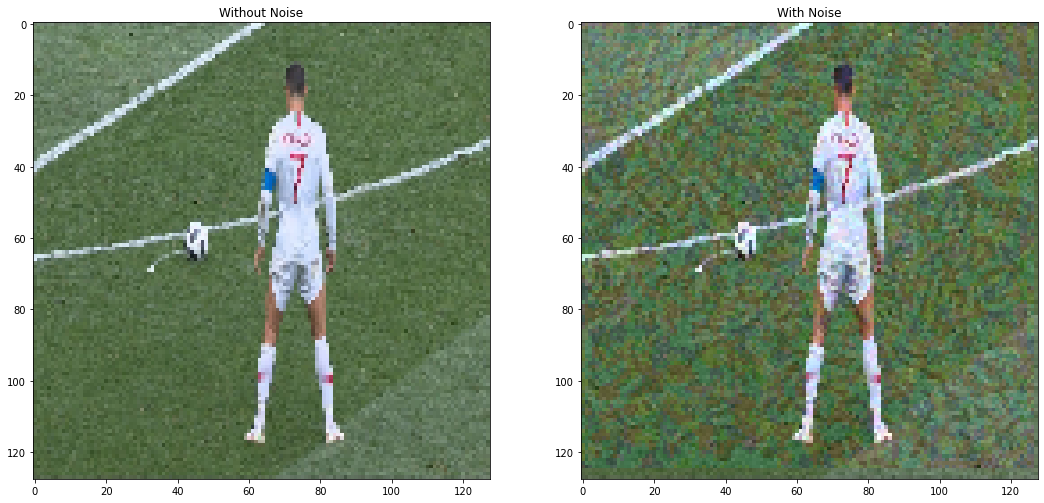

In [ ]:
# Attack
img1 = np.copy(Test_Image)
img2 = FGSMAttack(ClassificationModel, np.expand_dims(img1,axis=0))

Visualise(img1[0],img2[0], "Results/FGSM.png")

Performance

In [ ]:
Accuracy, Accuracy_FGSMAttack = Performance(ClassificationModel, Videos_Path, FGSMAttack)

ApplyEyeMakeup: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]



Class: ApplyEyeMakeup
Accuracy without FGSMAttack = 0.8
Accuracy with FGSMAttack = 0.8
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




ApplyLipstick: 100%|██████████| 20/20 [00:11<00:00,  1.78it/s]



Class: ApplyLipstick
Accuracy without FGSMAttack = 0.85
Accuracy with FGSMAttack = 0.85
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Archery: 100%|██████████| 20/20 [00:11<00:00,  1.77it/s]



Class: Archery
Accuracy without FGSMAttack = 0.95
Accuracy with FGSMAttack = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BabyCrawling: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]



Class: BabyCrawling
Accuracy without FGSMAttack = 0.85
Accuracy with FGSMAttack = 0.8
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




BalanceBeam: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]



Class: BalanceBeam
Accuracy without FGSMAttack = 0.8
Accuracy with FGSMAttack = 0.8
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




BandMarching: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]



Class: BandMarching
Accuracy without FGSMAttack = 0.95
Accuracy with FGSMAttack = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BaseballPitch: 100%|██████████| 20/20 [00:10<00:00,  1.97it/s]



Class: BaseballPitch
Accuracy without FGSMAttack = 0.9
Accuracy with FGSMAttack = 0.9
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Basketball: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]



Class: Basketball
Accuracy without FGSMAttack = 0.85
Accuracy with FGSMAttack = 0.85
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BasketballDunk: 100%|██████████| 20/20 [00:10<00:00,  1.94it/s]



Class: BasketballDunk
Accuracy without FGSMAttack = 1.0
Accuracy with FGSMAttack = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BenchPress: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]



Class: BenchPress
Accuracy without FGSMAttack = 1.0
Accuracy with FGSMAttack = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Biking: 100%|██████████| 20/20 [00:12<00:00,  1.66it/s]



Class: Biking
Accuracy without FGSMAttack = 0.9
Accuracy with FGSMAttack = 0.9
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Billiards: 100%|██████████| 20/20 [00:12<00:00,  1.57it/s]



Class: Billiards
Accuracy without FGSMAttack = 1.0
Accuracy with FGSMAttack = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BlowDryHair: 100%|██████████| 20/20 [00:12<00:00,  1.55it/s]



Class: BlowDryHair
Accuracy without FGSMAttack = 0.95
Accuracy with FGSMAttack = 0.9
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




BlowingCandles: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]



Class: BlowingCandles
Accuracy without FGSMAttack = 0.9
Accuracy with FGSMAttack = 0.9
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BodyWeightSquats: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]



Class: BodyWeightSquats
Accuracy without FGSMAttack = 0.6
Accuracy with FGSMAttack = 0.6
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Bowling: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]



Class: Bowling
Accuracy without FGSMAttack = 0.9
Accuracy with FGSMAttack = 0.85
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




BoxingPunchingBag: 100%|██████████| 20/20 [00:11<00:00,  1.69it/s]



Class: BoxingPunchingBag
Accuracy without FGSMAttack = 0.95
Accuracy with FGSMAttack = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BoxingSpeedBag: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]



Class: BoxingSpeedBag
Accuracy without FGSMAttack = 0.95
Accuracy with FGSMAttack = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BreastStroke: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]



Class: BreastStroke
Accuracy without FGSMAttack = 1.0
Accuracy with FGSMAttack = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BrushingTeeth: 100%|██████████| 20/20 [00:11<00:00,  1.69it/s]



Class: BrushingTeeth
Accuracy without FGSMAttack = 0.65
Accuracy with FGSMAttack = 0.65
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




CleanAndJerk: 100%|██████████| 20/20 [00:11<00:00,  1.69it/s]



Class: CleanAndJerk
Accuracy without FGSMAttack = 1.0
Accuracy with FGSMAttack = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




CliffDiving: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]



Class: CliffDiving
Accuracy without FGSMAttack = 0.95
Accuracy with FGSMAttack = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




CricketBowling: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]



Class: CricketBowling
Accuracy without FGSMAttack = 0.9
Accuracy with FGSMAttack = 0.85
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




CricketShot: 100%|██████████| 20/20 [00:10<00:00,  1.94it/s]



Class: CricketShot
Accuracy without FGSMAttack = 0.7
Accuracy with FGSMAttack = 0.7
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




CuttingInKitchen: 100%|██████████| 20/20 [00:11<00:00,  1.73it/s]



Class: CuttingInKitchen
Accuracy without FGSMAttack = 1.0
Accuracy with FGSMAttack = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Diving: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]



Class: Diving
Accuracy without FGSMAttack = 1.0
Accuracy with FGSMAttack = 0.95
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




Drumming: 100%|██████████| 20/20 [00:12<00:00,  1.59it/s]



Class: Drumming
Accuracy without FGSMAttack = 0.95
Accuracy with FGSMAttack = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Fencing: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]



Class: Fencing
Accuracy without FGSMAttack = 0.8
Accuracy with FGSMAttack = 0.8
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




FieldHockeyPenalty: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]



Class: FieldHockeyPenalty
Accuracy without FGSMAttack = 0.85
Accuracy with FGSMAttack = 0.85
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




FloorGymnastics: 100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


Class: FloorGymnastics
Accuracy without FGSMAttack = 0.7
Accuracy with FGSMAttack = 0.65
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




## Impact of PGD Attack

In [ ]:
def PGDAttack(Model, Frames, y=None, nb_iterations = 25, clip_min=0.0, clip_max=1.0, epsilon=0.1, epsilon_step=0.04):
    if len(Frames.shape) == 4:
        Frames = np.expand_dims(Frames, axis=0)

    Adv_Frames = projected_gradient_descent(
        model_fn = Model,
        x = Frames/255.0,
        eps = epsilon,
        eps_iter = epsilon_step,
        nb_iter = nb_iterations,
        norm = 2,
        clip_min = clip_min,
        clip_max = clip_max,
        targeted = False,
        y = y)[0]

    return np.uint8(255.0 * Adv_Frames.numpy())

Visualisation

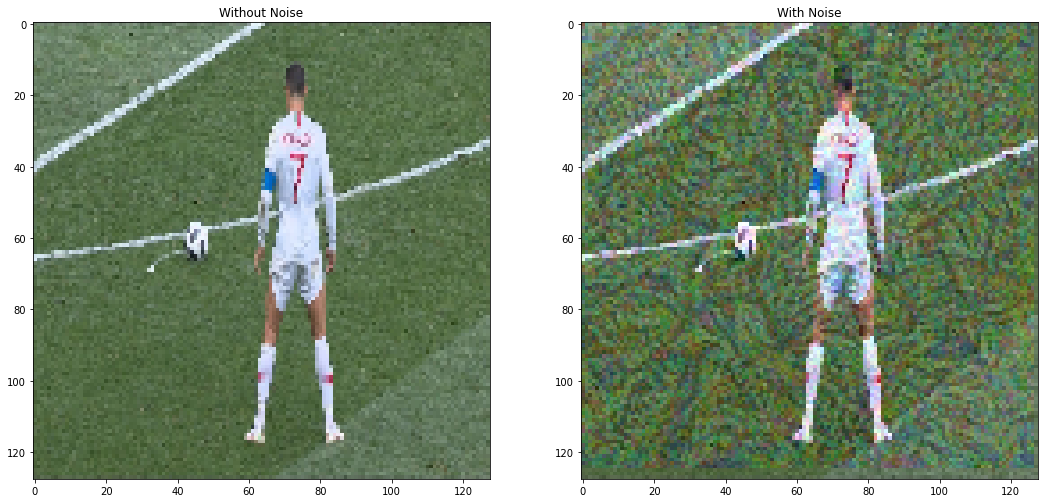

In [ ]:
# Attack
img1 = np.copy(Test_Image)
img2 = PGDAttack(ClassificationModel, np.expand_dims(img1,axis=0))

Visualise(img1[0],img2[0], "Results/PGD.png")

Performance

In [ ]:
Accuracy, Accuracy_PGDAttack = Performance(ClassificationModel, Videos_Path, PGDAttack)

ApplyEyeMakeup: 100%|██████████| 20/20 [01:41<00:00,  5.09s/it]



Class: ApplyEyeMakeup
Accuracy without PGDAttack = 0.8
Accuracy with PGDAttack = 0.85
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




ApplyLipstick: 100%|██████████| 20/20 [01:41<00:00,  5.10s/it]



Class: ApplyLipstick
Accuracy without PGDAttack = 0.85
Accuracy with PGDAttack = 0.85
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Archery: 100%|██████████| 20/20 [01:41<00:00,  5.09s/it]



Class: Archery
Accuracy without PGDAttack = 0.95
Accuracy with PGDAttack = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BabyCrawling: 100%|██████████| 20/20 [01:41<00:00,  5.09s/it]



Class: BabyCrawling
Accuracy without PGDAttack = 0.75
Accuracy with PGDAttack = 0.75
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




BalanceBeam: 100%|██████████| 20/20 [01:41<00:00,  5.08s/it]



Class: BalanceBeam
Accuracy without PGDAttack = 0.8
Accuracy with PGDAttack = 0.8
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BandMarching: 100%|██████████| 20/20 [01:42<00:00,  5.12s/it]



Class: BandMarching
Accuracy without PGDAttack = 0.95
Accuracy with PGDAttack = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BaseballPitch: 100%|██████████| 20/20 [01:40<00:00,  5.03s/it]



Class: BaseballPitch
Accuracy without PGDAttack = 0.95
Accuracy with PGDAttack = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Basketball: 100%|██████████| 20/20 [01:41<00:00,  5.06s/it]



Class: Basketball
Accuracy without PGDAttack = 0.9
Accuracy with PGDAttack = 0.85
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




BasketballDunk: 100%|██████████| 20/20 [01:40<00:00,  5.02s/it]



Class: BasketballDunk
Accuracy without PGDAttack = 1.0
Accuracy with PGDAttack = 0.95
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




BenchPress: 100%|██████████| 20/20 [01:41<00:00,  5.07s/it]



Class: BenchPress
Accuracy without PGDAttack = 0.95
Accuracy with PGDAttack = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Biking: 100%|██████████| 20/20 [01:41<00:00,  5.09s/it]



Class: Biking
Accuracy without PGDAttack = 0.95
Accuracy with PGDAttack = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Billiards: 100%|██████████| 20/20 [01:43<00:00,  5.16s/it]



Class: Billiards
Accuracy without PGDAttack = 1.0
Accuracy with PGDAttack = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BlowDryHair: 100%|██████████| 20/20 [01:42<00:00,  5.14s/it]



Class: BlowDryHair
Accuracy without PGDAttack = 0.95
Accuracy with PGDAttack = 0.9
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




BlowingCandles: 100%|██████████| 20/20 [01:40<00:00,  5.04s/it]



Class: BlowingCandles
Accuracy without PGDAttack = 0.9
Accuracy with PGDAttack = 0.85
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




BodyWeightSquats: 100%|██████████| 20/20 [01:40<00:00,  5.03s/it]



Class: BodyWeightSquats
Accuracy without PGDAttack = 0.55
Accuracy with PGDAttack = 0.55
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Bowling: 100%|██████████| 20/20 [01:41<00:00,  5.06s/it]



Class: Bowling
Accuracy without PGDAttack = 0.95
Accuracy with PGDAttack = 0.85
Accuracy between Predictions =  0.9
----------------------------------------------------------------------------------------------------




BoxingPunchingBag: 100%|██████████| 20/20 [01:41<00:00,  5.09s/it]



Class: BoxingPunchingBag
Accuracy without PGDAttack = 0.95
Accuracy with PGDAttack = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BoxingSpeedBag: 100%|██████████| 20/20 [01:42<00:00,  5.14s/it]



Class: BoxingSpeedBag
Accuracy without PGDAttack = 1.0
Accuracy with PGDAttack = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BreastStroke: 100%|██████████| 20/20 [01:41<00:00,  5.07s/it]



Class: BreastStroke
Accuracy without PGDAttack = 1.0
Accuracy with PGDAttack = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




BrushingTeeth: 100%|██████████| 20/20 [01:42<00:00,  5.11s/it]



Class: BrushingTeeth
Accuracy without PGDAttack = 0.65
Accuracy with PGDAttack = 0.65
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




CleanAndJerk: 100%|██████████| 20/20 [01:41<00:00,  5.08s/it]



Class: CleanAndJerk
Accuracy without PGDAttack = 1.0
Accuracy with PGDAttack = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




CliffDiving: 100%|██████████| 20/20 [01:40<00:00,  5.03s/it]



Class: CliffDiving
Accuracy without PGDAttack = 1.0
Accuracy with PGDAttack = 1.0
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




CricketBowling: 100%|██████████| 20/20 [01:41<00:00,  5.07s/it]



Class: CricketBowling
Accuracy without PGDAttack = 0.85
Accuracy with PGDAttack = 0.9
Accuracy between Predictions =  0.95
----------------------------------------------------------------------------------------------------




CricketShot: 100%|██████████| 20/20 [01:40<00:00,  5.05s/it]



Class: CricketShot
Accuracy without PGDAttack = 0.75
Accuracy with PGDAttack = 0.75
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




CuttingInKitchen: 100%|██████████| 20/20 [01:41<00:00,  5.09s/it]



Class: CuttingInKitchen
Accuracy without PGDAttack = 0.95
Accuracy with PGDAttack = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Diving: 100%|██████████| 20/20 [01:41<00:00,  5.08s/it]



Class: Diving
Accuracy without PGDAttack = 0.95
Accuracy with PGDAttack = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Drumming: 100%|██████████| 20/20 [01:43<00:00,  5.18s/it]



Class: Drumming
Accuracy without PGDAttack = 0.95
Accuracy with PGDAttack = 0.95
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




Fencing: 100%|██████████| 20/20 [01:40<00:00,  5.05s/it]



Class: Fencing
Accuracy without PGDAttack = 0.8
Accuracy with PGDAttack = 0.8
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




FieldHockeyPenalty: 100%|██████████| 20/20 [01:41<00:00,  5.05s/it]



Class: FieldHockeyPenalty
Accuracy without PGDAttack = 0.8
Accuracy with PGDAttack = 0.8
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




FloorGymnastics: 100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


Class: FloorGymnastics
Accuracy without PGDAttack = 0.75
Accuracy with PGDAttack = 0.75
Accuracy between Predictions =  1.0
----------------------------------------------------------------------------------------------------




## Plotting Results

Results

In [ ]:
Results = [(Accuracy, "Without Attack"),
           (Accuracy_FGSMAttack, "FGSM Attack"),
           (Accuracy_PGDAttack, "PGD Attack")]

Plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


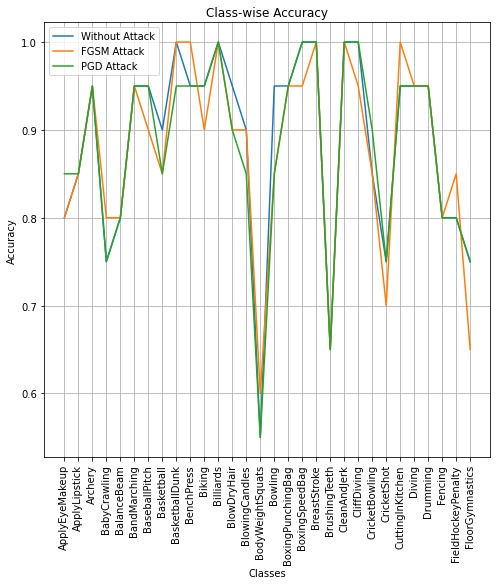

In [ ]:
plt.figure(figsize=(8,8))
plt.title("Class-wise Accuracy")
plt.xlabel("Classes")
plt.ylabel("Accuracy")
plt.grid()
X = np.arange(N)
plt.xticks(X, Classes, rotation=90)
for Acc, Desc in Results:
    plt.plot(X, Acc, label=Desc)
plt.legend()
plt.savefig("Results/Standard-Adversarial-Attack.eps")
plt.show()